In [1]:
import sys

sys.path.append("../")

from io import StringIO

import numpy as np

import evoten

evoten.set_backend("tensorflow")

# parse a tree
handle = StringIO("(A:0.1,B:0.2,(C:0.3,D:0.4)E:0.5)F;")
tree = evoten.TreeHandler.read(handle)

# leaves with final shape (n, 1, L, d)
leaves = np.array([[0,2,3],
                   [1,1,0],
                   [2,1,0],
                   [3,1,2]])
leaves = np.eye(4)[leaves]
leaves = leaves[:,np.newaxis] # model dimension, here we'll use a single model

leaf_names = ['A', 'B', 'C', 'D']

# use a rate matrix, here Jukes-Cantor, shape (1, d, d)
rate_matrix = np.array([[[-1, 1./3, 1./3, 1./3],
                         [1./3, -1, 1./3, 1./3],
                         [1./3, 1./3, -1, 1./3],
                         [1./3, 1./3, 1./3, -1]]])

leaves = leaves.astype(evoten.util.default_dtype)
rate_matrix = rate_matrix.astype(evoten.util.default_dtype)

# compute the loglikelihood log P(leaves | tree)
transition_probs = evoten.backend.make_transition_probs(
    rate_matrix,
    tree.branch_lengths
)
# add the length dimension (broadcasting)
# the inputs have one, so transition probs also need one
transition_probs = transition_probs[:,:,np.newaxis]
L = evoten.model.loglik(
    leaves,
    tree,
    transition_probs,
    equilibrium_logits=np.log([[1./4, 1./4, 1./4, 1./4]]),
    leaf_names=leaf_names,
    leaves_are_probabilities=True
)

print("Loglikelihood: ", L)

2025-10-16 14:57:20.403209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760619442.180511  538406 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Loglikelihood:  tf.Tensor([[-7.605143  -5.7625747 -7.249683 ]], shape=(1, 3), dtype=float32)


I0000 00:00:1760619444.034856  538406 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x623c9a12bba0


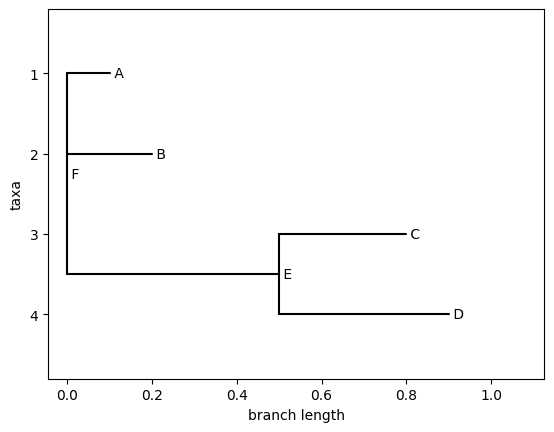

In [2]:
# draw and save as png
import matplotlib.pyplot as plt

figure, ax = plt.subplots()
tree.draw(axes=ax)
figure.savefig("example.png")

In [3]:
# compute marginal distributions at all ancestral nodes, i.e. P(ancestral_node | leaves, tree) 
M = evoten.model.compute_ancestral_marginals(
    leaves,
    tree,
    transition_probs,
    equilibrium_logits=np.log([[1./4, 1./4, 1./4, 1./4]]),
    leaf_names=leaf_names,
    leaves_are_probabilities=True,
    return_probabilities=True
)

ancestral_names = ["E", "F"]
for i in range(len(ancestral_names)):
    print("Marginal distributions of node", ancestral_names[i], ":\n", M[i].numpy())

Marginal distributions of node E :
 [[[0.15933783 0.09937008 0.42822528 0.31306723]
  [0.0074275  0.9599043  0.02524071 0.0074275 ]
  [0.63605314 0.03286138 0.21941343 0.11167206]]]
Marginal distributions of node F :
 [[[0.60789233 0.29487458 0.05354059 0.04369259]
  [0.01026389 0.68136317 0.2981091  0.01026389]
  [0.52866733 0.01466862 0.03062199 0.42604187]]]



Depending on the chosen backend, L and M are TensorFlow or Pytorch Tensors that can be differentiated with respect to leaves, branch lengths or rates.

For more detailed examples please see unit tests.